In [28]:
%%capture
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

In [20]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import spearmanr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.util_plot as nmd_plot
from tools import NMD as nmd

import warnings
warnings.filterwarnings("ignore")

import importlib

In [47]:
from scipy.stats import kendalltau, spearmanr

In [48]:
def plot_reconstruction(
    X_reconstruction, X,hue=None, type="scatter", sample_fraction=None
):
    """Plot original sparse non-negative matrix against the reconstructed one

    Also computes the Pearson correlation between both

    Args:
        X_reconstruction (_type_): Reconstructed matrix, e.g. np.maximum(0, Theta)
        X (_type_): The original sparse non-negative matrix
        title (_type_): _description_
        type (str, optional): _description_. Defaults to "scatter".
        sample_fraction (_type_, optional): _description_. Defaults to None.
    """
    X_recon_max = np.max(X_reconstruction)
    X_max = np.max(X)
    max_axis = max(X_recon_max, X_max)
    #correlation = np.corrcoef(X_reconstruction.flatten(), X.flatten())[0][1]

    df = pd.DataFrame(
        {"original": X.flatten(), "reconstruction": X_reconstruction.flatten().round(0)}
    )
    
    correlation = kendalltau(df["original"], df["reconstruction"]).statistic

    if sample_fraction:
        df = df.sample(frac=sample_fraction, axis=0)

    fig, ax = plt.subplots()
    match type:
        case "scatter":
            if hue is not None:
                p = sns.scatterplot(data=df, x="reconstruction", y="original", hue=hue, alpha=0.05)
            else:
                p = sns.scatterplot(data=df, x="reconstruction", y="original", alpha=0.05)
        # case "kde":
        # p = sns.kdeplot(X_reconstruction.flatten(), X.flatten())
        # p = sns.kdeplot(data=df, x="reconstruction", y="original")
    #p.set_ylim(0, max_axis)
    #p.set_xlim(0, max_axis)
    #plt.suptitle(title)
    plt.title(f"Kendall's tau: {round(correlation, 3)}")
    plt.xlabel("Reconstruction")
    plt.ylabel("Original data")
    ax.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
    plt.show()


In [22]:
data_all_pca = sc.read_h5ad("../../data/MOBA_scRNAseq/MOBA_intermediate_results/export_s3.h5ad")
data_all_pca

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'total_counts', 'n_genes_by_counts', 'leiden_opt'
    var: 'total_counts', 'n_cells_by_counts', 'TU_ID', 'nb_overdisp_cutoff', 'pval_cluster_0', 'pval_cluster_1', 'pval_cluster_2', 'pval_cluster_3'
    uns: 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [23]:
data_all_pca.varm["PCs"].shape

(5553, 50)

In [24]:
data_counts = sc.read_h5ad("../../data/MOBA_scRNAseq/MOBA_intermediate_results/S3_filtered_with_counts.h5ad")
data_counts

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'

In [25]:
importlib.reload(nmd_plot)

<module 'tools.util_plot' from '/dss/dsshome1/07/di35buw/NMD/BacSC/tools/util_plot.py'>

In [26]:
data_all_pca.uns["leiden_opt_colors"]

array(['#1f77b4', '#d62728', '#e377c2', '#17becf'], dtype=object)

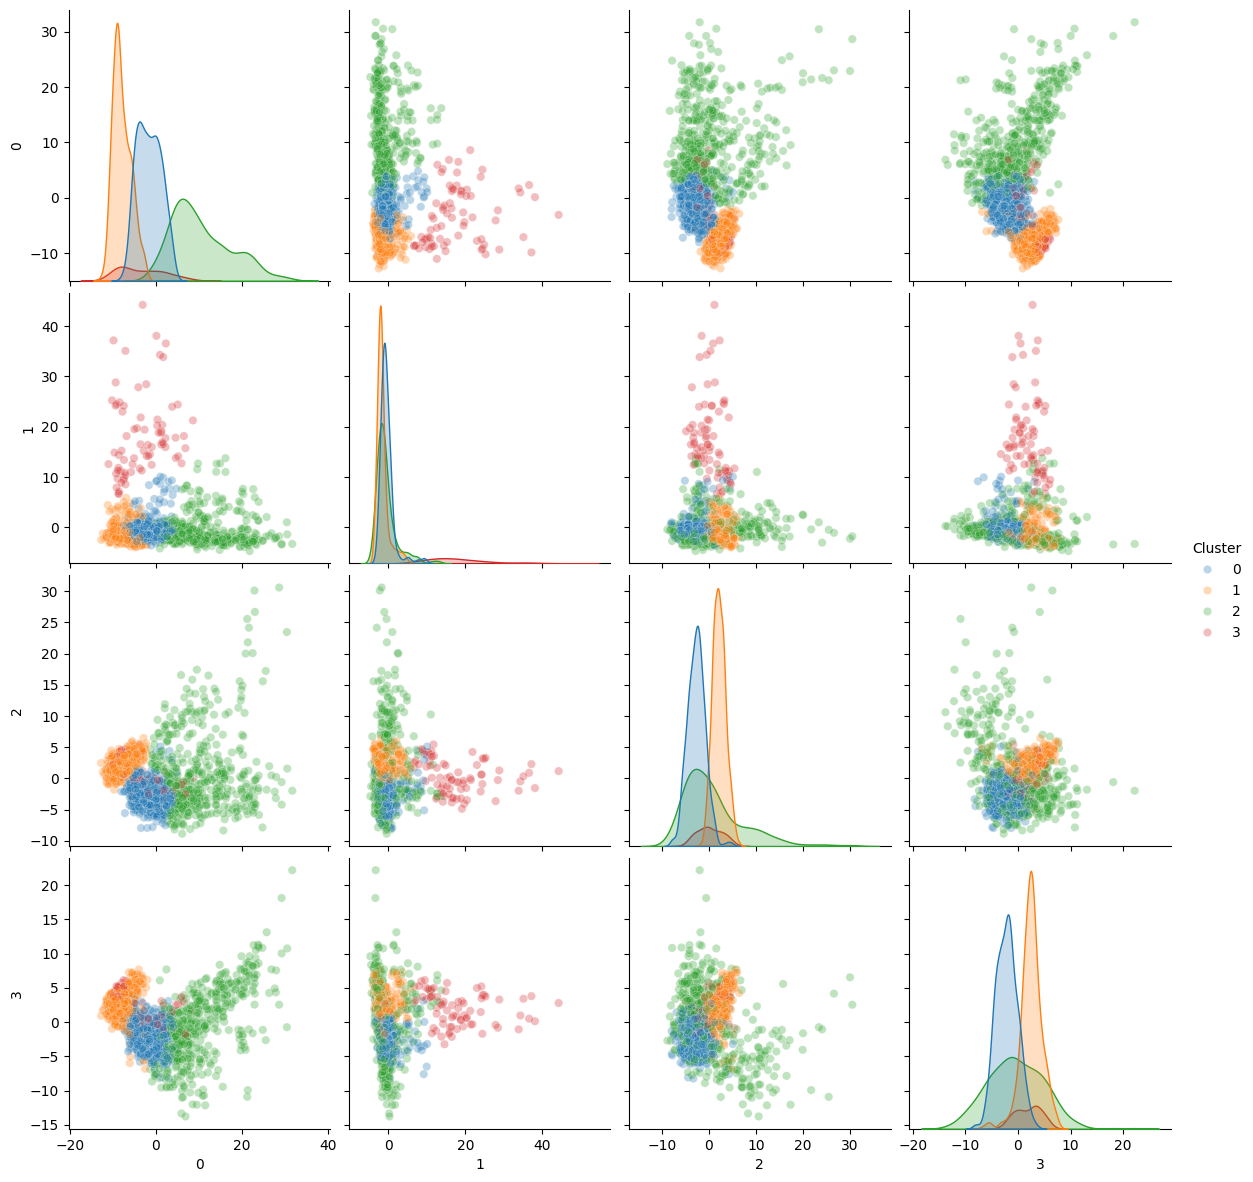

In [27]:
nmd_plot.plot_embedding_grid(data_all_pca.obsm["X_pca"][:,:4], hue=data_all_pca.obs["leiden_opt"], size=3)

## Fit NMD

In [19]:
np.sum(X_nmd == 0) / X_nmd.size

0.8624071477024509

In [28]:
k_opt = 2 # to match pca
beta_opt = 0.5
data_layer = "counts"

In [10]:
m, n = data_counts.X.shape
X_nmd = ut.convert_to_dense_counts(data_counts, layer=data_layer)
m, n = X_nmd.shape
W0, H0 = cs.nuclear_norm_init(X_nmd, m, n, k_opt)
Theta0 = W0 @ H0

In [11]:
Theta_3b, W_3b, H_3b, loss_3b, iters_3b, times_3b = nmd.nmd_3b(X_nmd, r=k_opt, W0=W0, H0=H0, beta1=beta_opt, tol_over_10iters=1e-4)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 53.767592] - 0.628067 secs
[1 : 53.230347] - 0.641729 secs
[2 : 52.358348] - 0.640483 secs
[3 : 51.423031] - 0.637784 secs
[4 : 50.976018] - 0.627877 secs
[5 : 50.904700] - 0.653411 secs
[6 : 50.865830] - 0.643940 secs
[7 : 50.853370] - 0.648213 secs
[8 : 50.846825] - 0.633444 secs
[9 : 50.842545] - 0.646699 secs
[10 : 50.839232] - 0.646696 secs
[11 : 50.836718] - 0.638497 secs
[12 : 50.834678] - 0.629548 secs
[13 : 50.833110] - 0.644498 secs
[14 : 50.831813] - 0.645692 secs
[15 : 50.830733] - 0.638042 secs
[16 : 50.829821] - 0.630670 secs
[17 : 50.829049] - 0.642086 secs
[18 : 50.828381] - 0.651632 secs
[19 : 50.827811] - 0.678654 secs
[20 : 50.827323] - 0.632125 secs

Converged: abs(rel. err.(i) - rel. err.(i-10)) < 0.0001

Final relative error: 50.82690857935434%, after 22 iterations.
Initialization time: 0.441093 secs
Mean time per iteration: 0.634911 secs
Total time: 14.409132 secs



In [12]:
importlib.reload(nmd_plot)

<module 'tools.util_plot' from '/dss/dsshome1/07/di35buw/NMD/BacSC/tools/util_plot.py'>

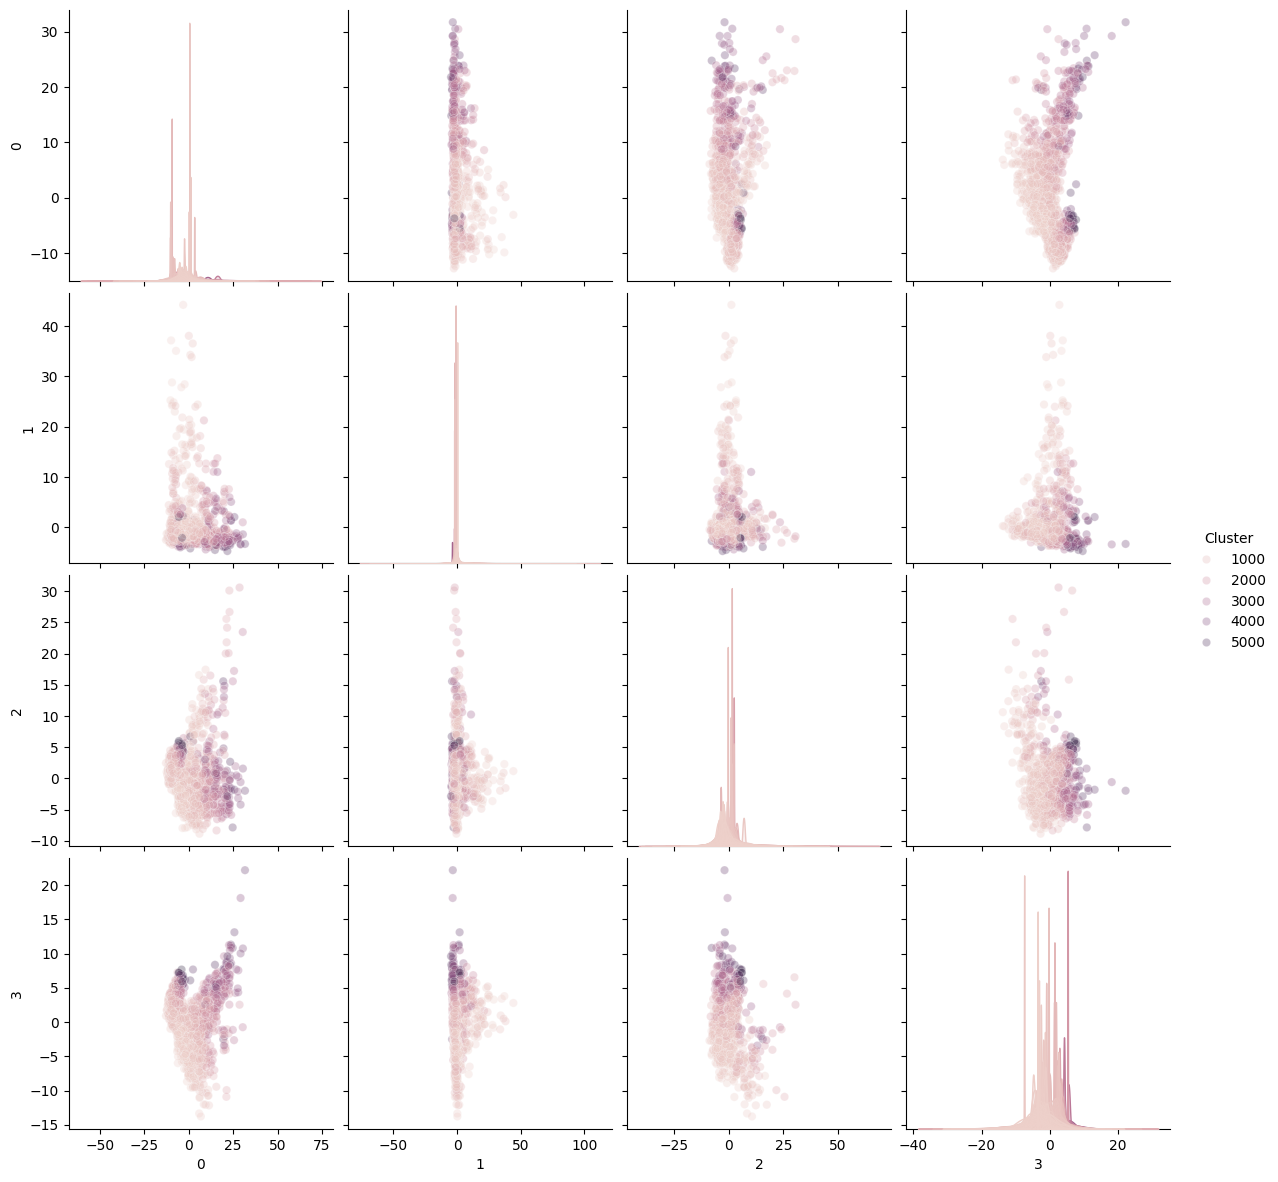

In [13]:
nmd_plot.plot_embedding_grid(data_all_pca.obsm["X_pca"][:,:4], hue=data_counts.obs["total_counts"], size=3)

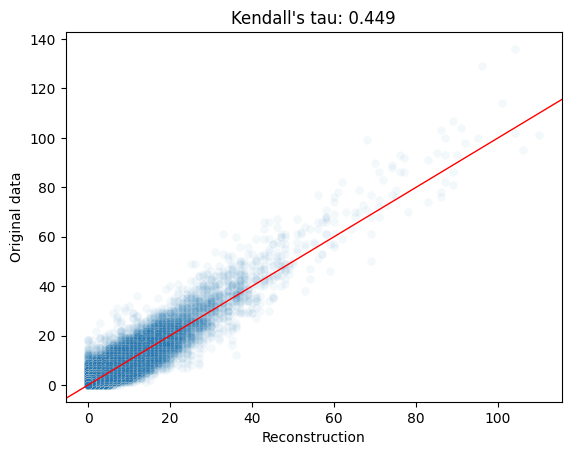

In [49]:
plot_reconstruction(np.maximum(0, W0@H0), X_nmd)

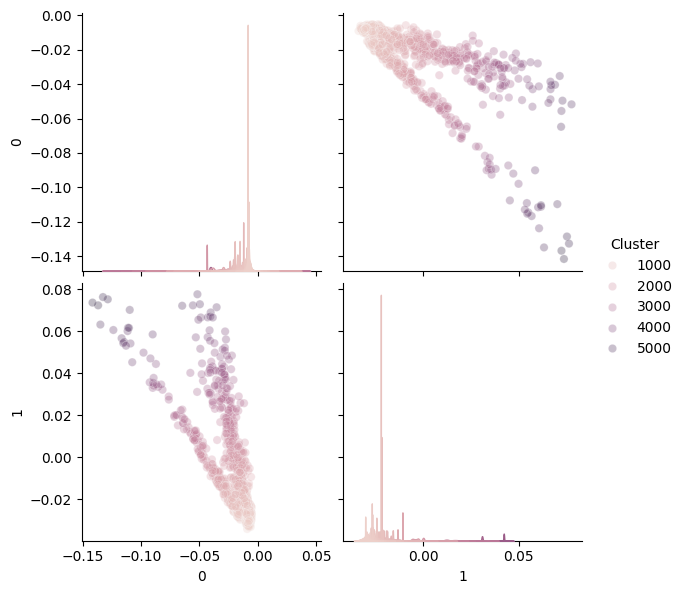

In [51]:
nmd_plot.plot_embedding_grid(W0, hue=data_counts.obs["total_counts"], size=3, hue_label="Sequencing depth")

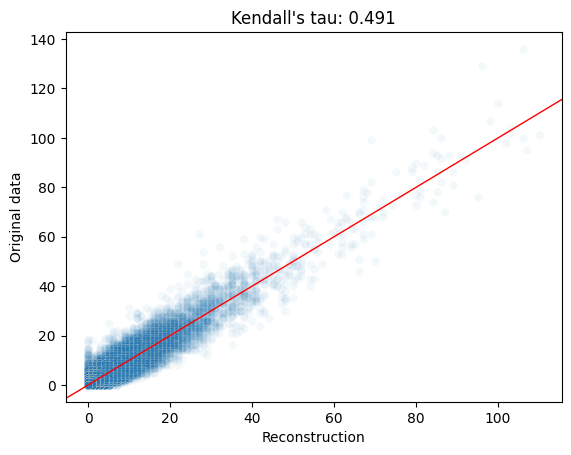

In [50]:
plot_reconstruction(np.maximum(0, W_3b@H_3b), X_nmd)

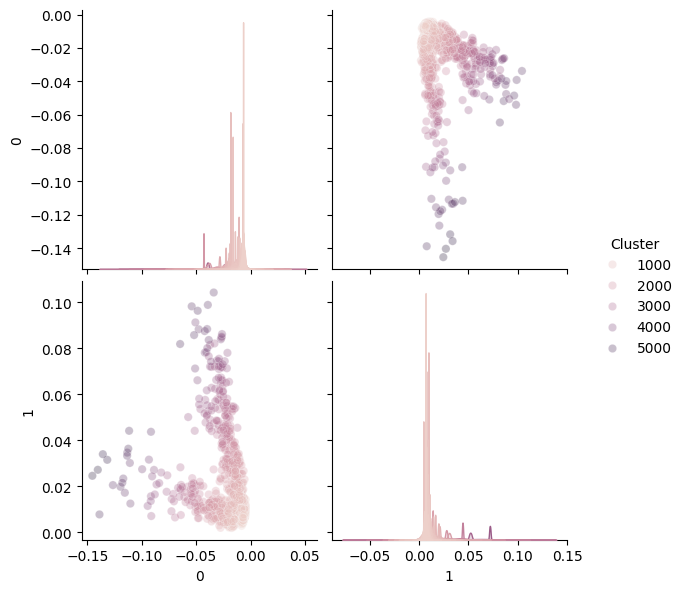

In [30]:
nmd_plot.plot_embedding_grid(W_3b, hue=data_counts.obs["total_counts"], size=3)

In [52]:
data_counts

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'

Cluster 3: vermutlich selbes expression profile aber geringere Sequencingdepth

<Axes: >

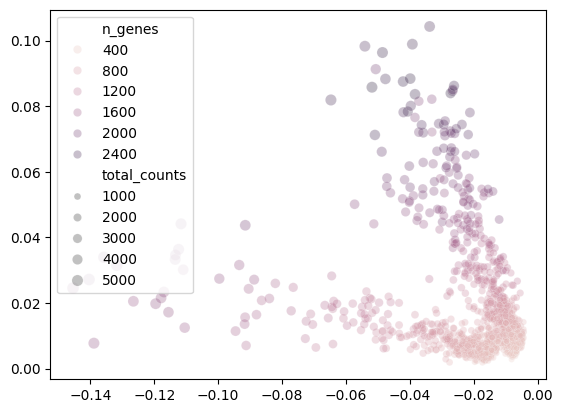

In [55]:
sns.scatterplot(x = W_3b[:,0], y=W_3b[:,1], 
                size=data_counts.obs["total_counts"], 
                alpha=0.3, hue=data_counts.obs["n_genes"], legend="brief")

In [73]:
df_seq_depth_emb = pd.DataFrame(
    {"NMD Dim 0": W_3b[:,0], 
     "NMD Dim 1": W_3b[:,1], 
     "Sequencing Depth": data_counts.obs["total_counts"],
    "Number of expressed genes": data_counts.obs["n_genes"]}
)

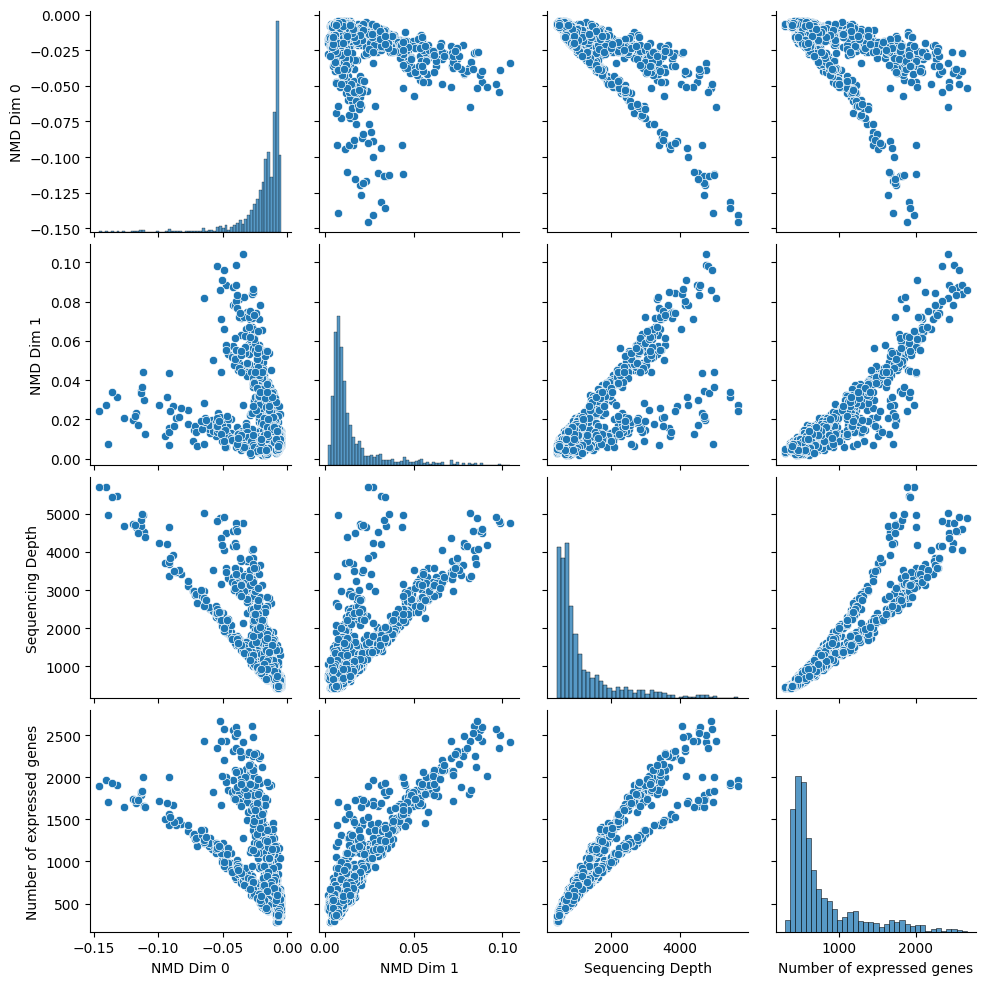

In [74]:
sns.pairplot(df_seq_depth_emb)

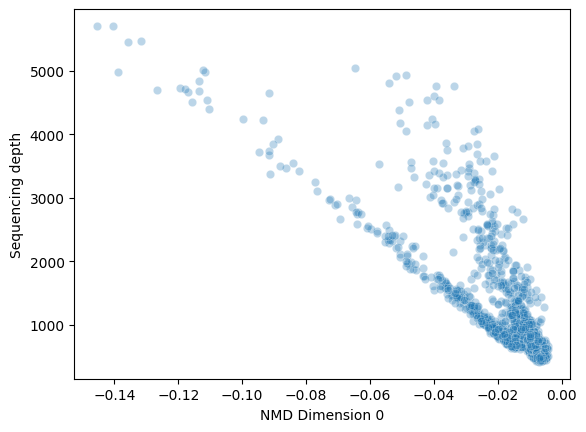

In [71]:
sns.scatterplot(x=W_3b[:,0], y=data_counts.obs["total_counts"], alpha=0.3)
plt.xlabel("NMD Dimension 0")
plt.ylabel("Sequencing depth")
plt.show()

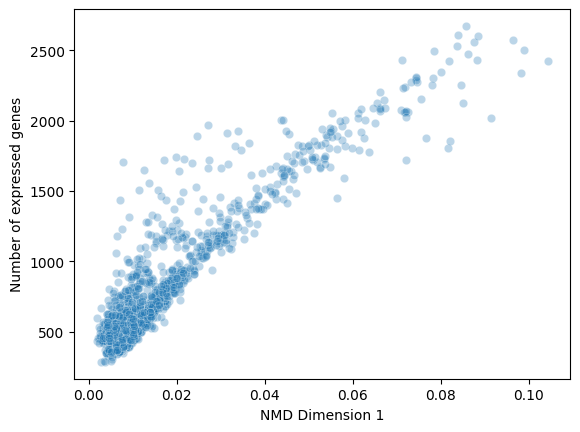

In [72]:
sns.scatterplot(x=W_3b[:,1], y=data_counts.obs["n_genes"], alpha=0.3)
plt.xlabel("NMD Dimension 1")
plt.ylabel("Number of expressed genes")
plt.show()

In [54]:
data_train, data_test = cs.countsplit_adata(data_counts, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)

In [55]:
data_counts.obsm["X_3b"] = W_3b.copy()

In [56]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(
    data_counts, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=5678, layer = "counts",
    embedding_method="UMAP", similarity_percent=0.5, save_path="S2_filtered_scdeed_nmd")

calculating (10, 0.05) - run 1/85


2024-03-15 10:19:46.470783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 10:19:46.470915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 10:19:46.472929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 10:19:46.485735: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 0.7) - run 30/85
calculating (40, 

Optimal number of neighbors: 25
Optimal min_dist: 0.3


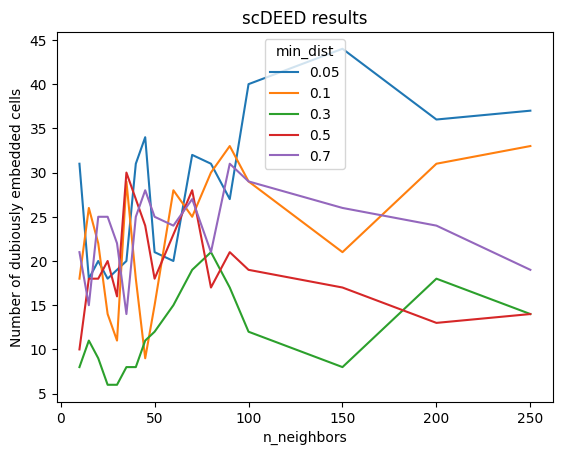

In [57]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [58]:
sc.pp.neighbors(data_counts, n_neighbors=n_neighbors_opt, n_pcs=k_opt, use_rep="X_3b")
sc.tl.umap(data_counts, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

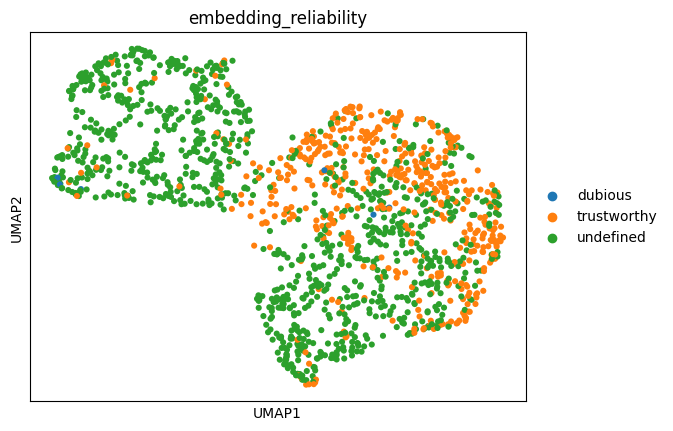

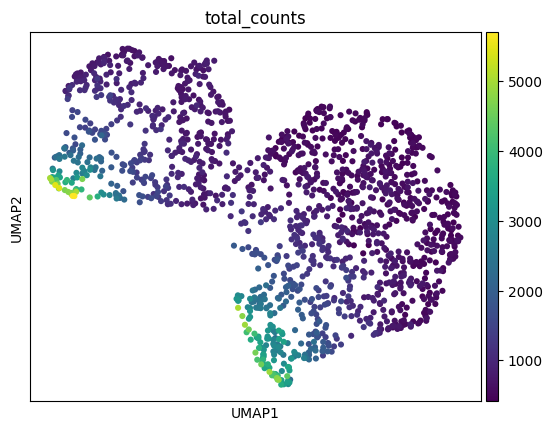

In [59]:
sc.pl.umap(data_counts, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_counts, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [60]:
X_train = ut.convert_to_dense_counts(data_train, layer=data_layer)
m, n = X_train.shape
W0_train, H0_train = cs.nuclear_norm_init(X_train, m, n, k_opt)

In [61]:
X_test = ut.convert_to_dense_counts(data_test, layer=data_layer)
m, n = X_test.shape
W0_test, H0_test = cs.nuclear_norm_init(X_test, m, n, k_opt)

In [62]:
_, W_train, H_train,  _, _, _ = nmd.nmd_3b(X_train, r=k_opt, W0=W0_train, H0=H0_train, beta1=.8)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 66.571943] - 0.688071 secs
[1 : 66.383773] - 0.689714 secs
[2 : 66.493727] - 0.686393 secs
[3 : 66.592652] - 0.695859 secs
[4 : 66.449827] - 0.688160 secs
[5 : 66.328815] - 0.687042 secs
[6 : 66.172420] - 0.683792 secs
[7 : 66.017527] - 0.692236 secs
[8 : 65.870814] - 0.699634 secs
[9 : 65.743118] - 0.696303 secs
[10 : 65.668682] - 0.704905 secs
[11 : 65.548767] - 0.706877 secs
[12 : 65.538726] - 0.701897 secs
[13 : 65.510918] - 0.789139 secs
[14 : 65.471448] - 0.685604 secs
[15 : 65.469906] - 0.688498 secs
[16 : 65.447982] - 0.690877 secs
[17 : 65.422313] - 0.686871 secs
[18 : 65.441341] - 0.680910 secs
[19 : 65.401872] - 0.685924 secs
[20 : 65.387707] - 0.692904 secs
[21 : 65.403477] - 0.685636 secs
[22 : 65.389960] - 0.684344 secs
[23 : 65.375812] - 0.686277 secs
[24 : 65.394663] - 0.688066 secs
[25 : 65.373027] - 0.684187 secs
[26 : 65.365892] - 0.685716 secs
[27 : 65.379761] - 0.682327 

In [63]:
_, W_test, H_test,  _, _, _ = nmd.nmd_3b(X_test, r=k_opt, W0=W0_test, H0=H0_test, beta1=.8)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 66.904639] - 0.682553 secs
[1 : 66.708786] - 0.698216 secs
[2 : 66.825489] - 0.682449 secs
[3 : 66.926600] - 0.687357 secs
[4 : 66.733237] - 0.686806 secs
[5 : 66.588459] - 0.690801 secs
[6 : 66.432095] - 0.688855 secs
[7 : 66.257025] - 0.689114 secs
[8 : 66.150327] - 0.684157 secs
[9 : 66.018372] - 0.686132 secs
[10 : 65.980538] - 0.680808 secs
[11 : 65.860770] - 0.689178 secs
[12 : 65.865492] - 0.687127 secs
[13 : 65.850632] - 0.687197 secs
[14 : 65.794207] - 0.685117 secs
[15 : 65.799583] - 0.682269 secs
[16 : 65.777034] - 0.682743 secs
[17 : 65.742589] - 0.689096 secs
[18 : 65.757923] - 0.691623 secs
[19 : 65.725527] - 0.683868 secs
[20 : 65.716932] - 0.683398 secs
[21 : 65.733960] - 0.686034 secs
[22 : 65.721568] - 0.686586 secs
[23 : 65.705459] - 0.684595 secs
[24 : 65.726208] - 0.693789 secs
[25 : 65.704600] - 0.688222 secs
[26 : 65.694913] - 0.690766 secs
[27 : 65.711696] - 0.689401 

In [64]:
data_train.obsm["X_3b"] = W_train
data_test.obsm["X_3b"] = W_test

In [65]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt, use_rep="X_3b")
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt, use_rep="X_3b")
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

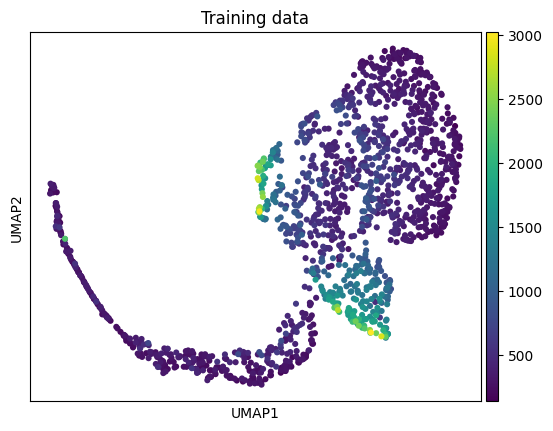

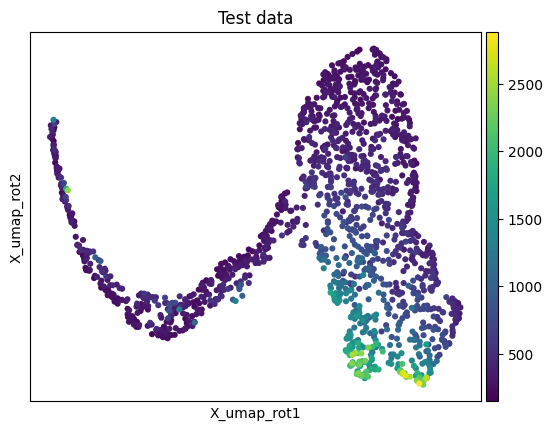

In [66]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

In [67]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

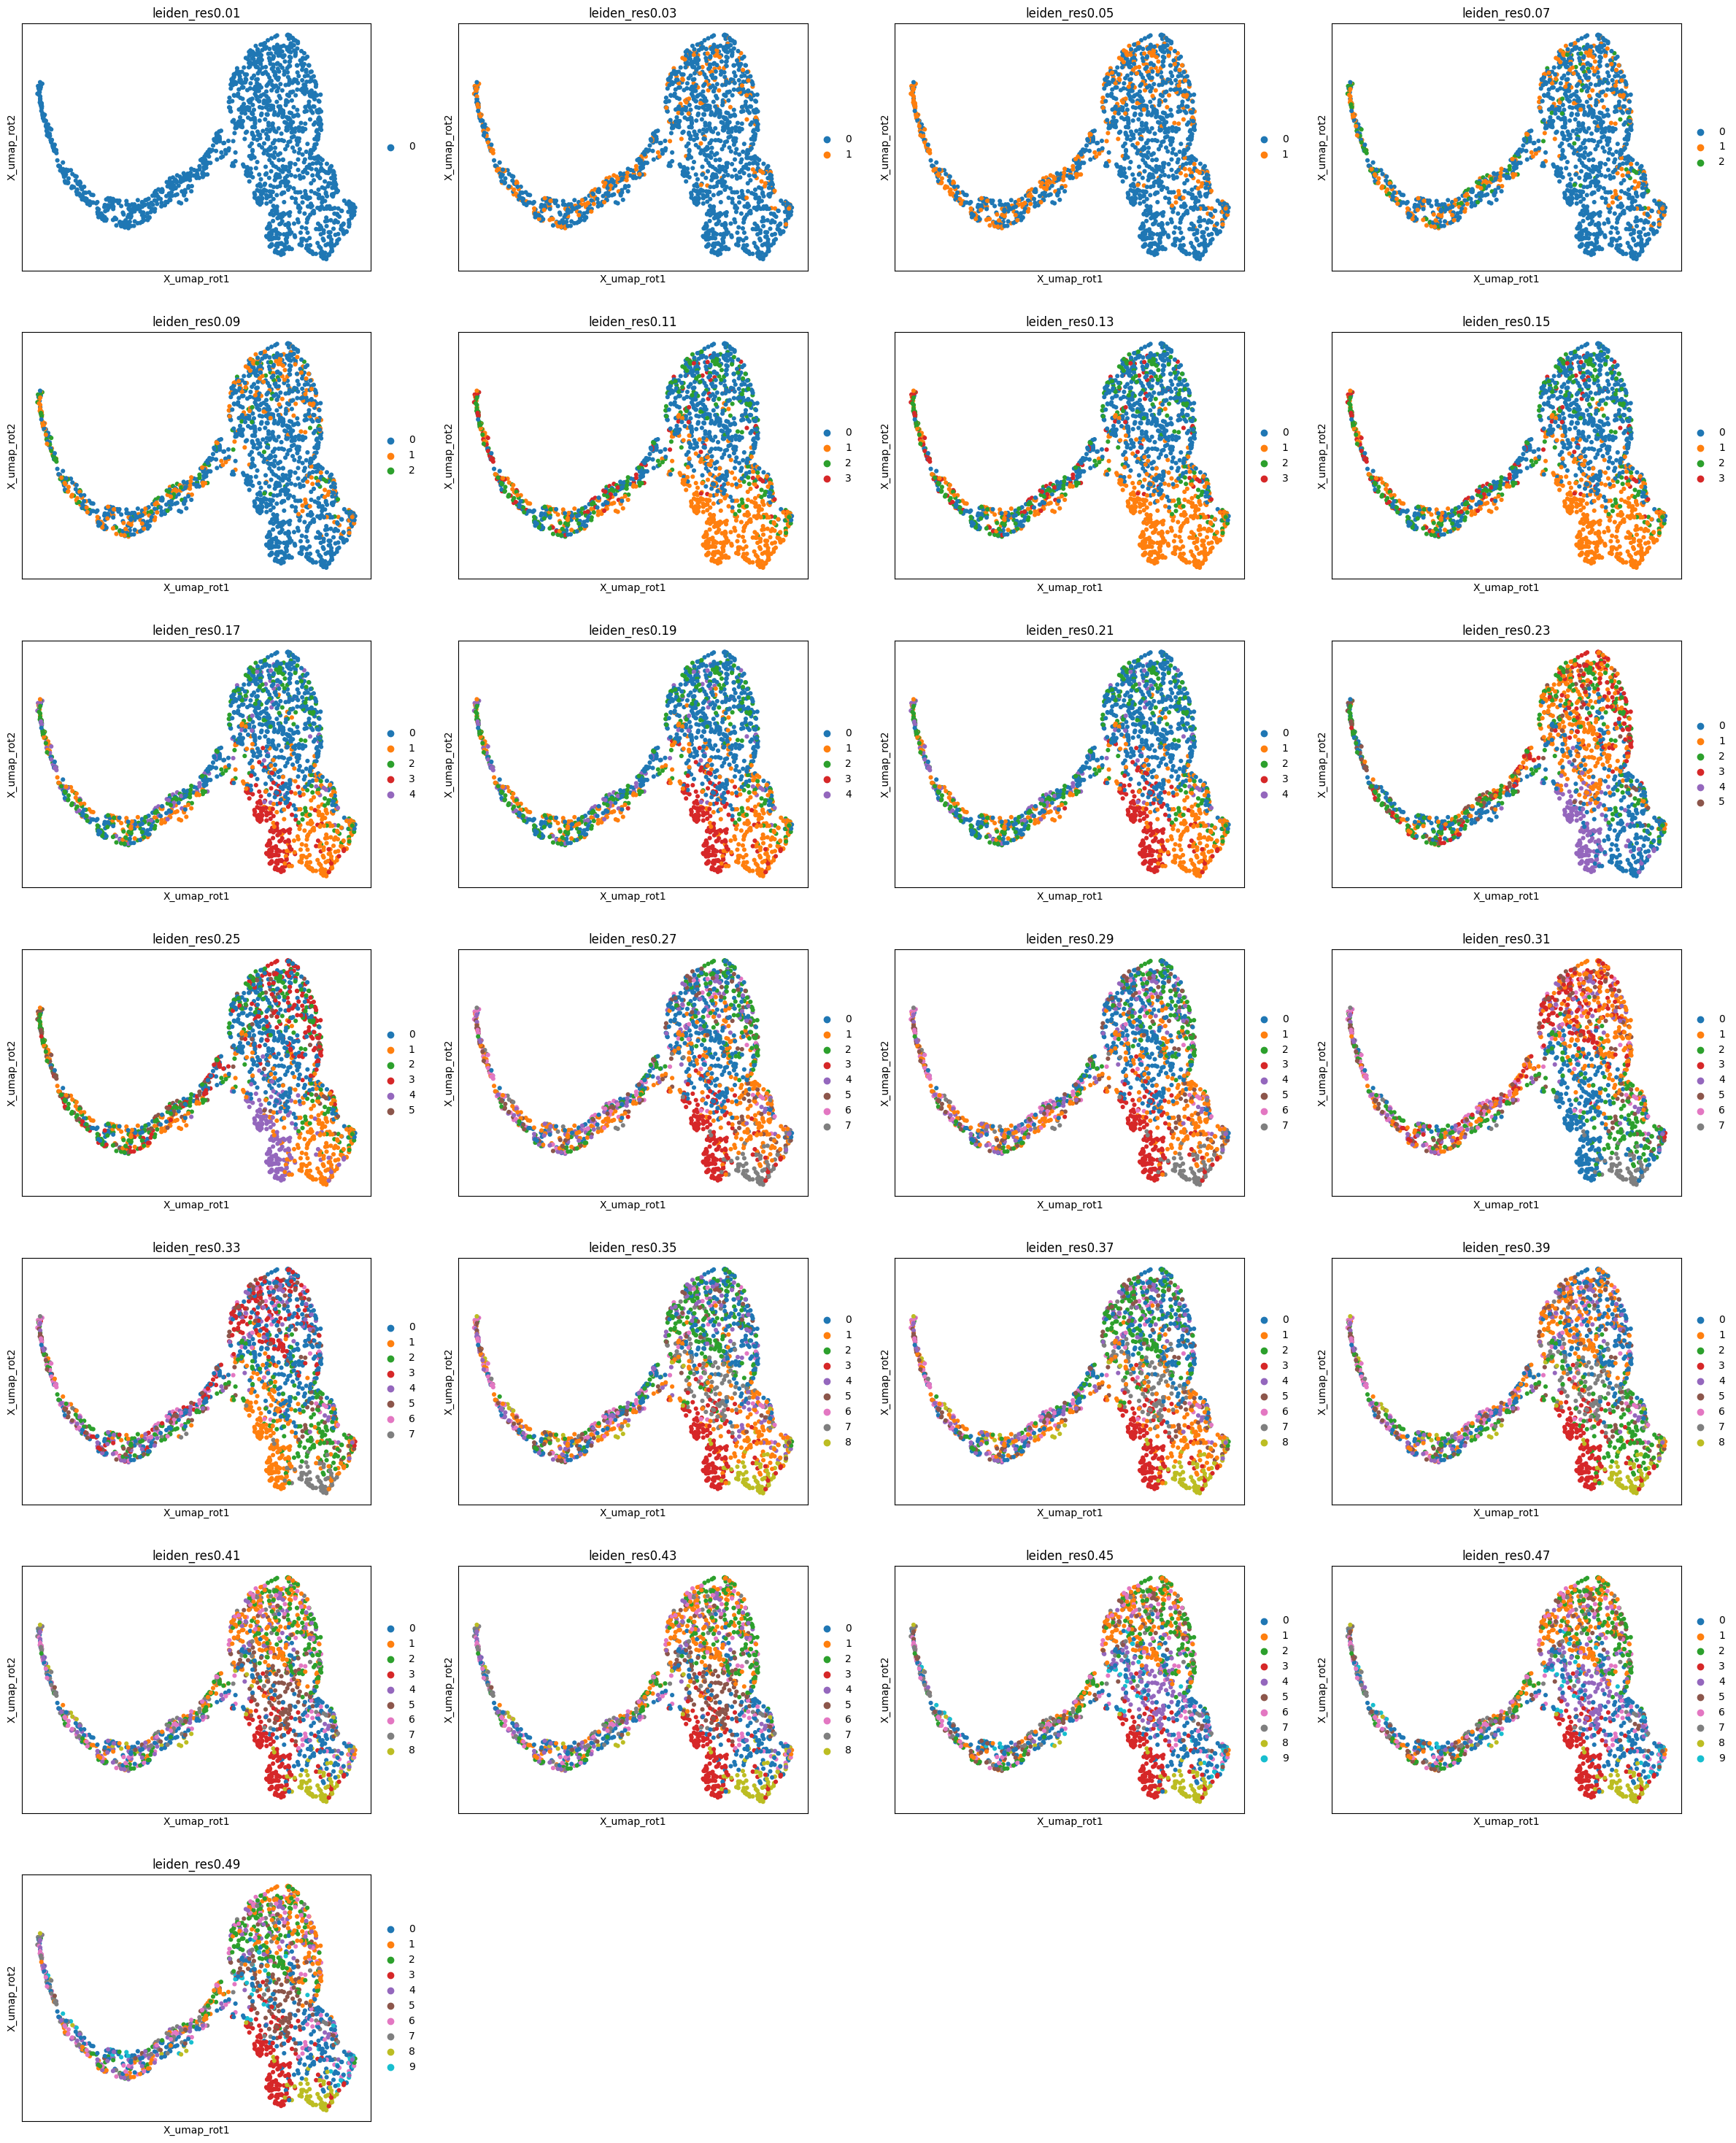

In [68]:
sc.pl.embedding(data_test, basis="X_umap_rot", color=[f"leiden_res{resolution}" for resolution in resolutions])
plt.show()

In [69]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 2 - Train: 0.475 - Test: 0.358 - Random: 0.333
resolution: 0.05 - clusters: 2 - Train: 0.461 - Test: 0.315 - Random: 0.276
resolution: 0.07 - clusters: 3 - Train: 0.448 - Test: 0.283 - Random: 0.251
resolution: 0.09 - clusters: 3 - Train: 0.436 - Test: 0.272 - Random: 0.24
resolution: 0.11 - clusters: 4 - Train: 0.435 - Test: 0.24 - Random: 0.124
resolution: 0.13 - clusters: 4 - Train: 0.429 - Test: 0.234 - Random: 0.116
resolution: 0.15 - clusters: 4 - Train: 0.423 - Test: 0.228 - Random: 0.11
resolution: 0.17 - clusters: 5 - Train: 0.418 - Test: 0.207 - Random: 0.085
resolution: 0.19 - clusters: 5 - Train: 0.413 - Test: 0.199 - Random: 0.082
resolution: 0.21 - clusters: 5 - Train: 0.407 - Test: 0.195 - Random: 0.078
resolution: 0.23 - clusters: 6 - Train: 0.406 - Test: 0.16 - Random: 0.052
resolution: 0.25 - clusters: 6 - Train: 0.402 - Test: 0.159 - Random: 0.046
resolution: 0.27 - 

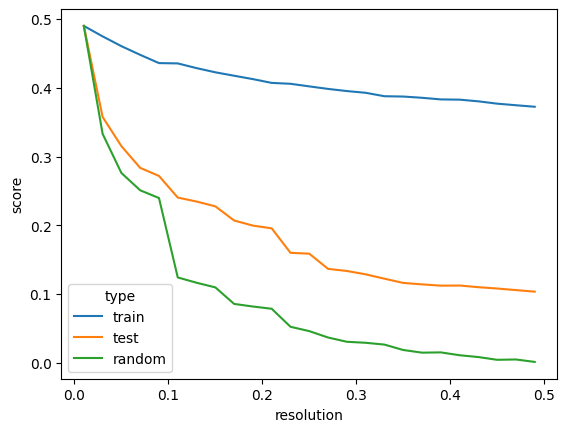

In [70]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.show()

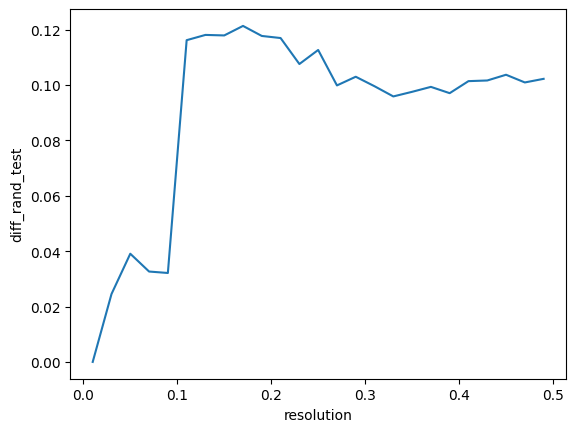

In [71]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.show()

In [72]:
sc.tl.leiden(data_counts, resolution=res_opt, key_added="leiden_opt")

In [73]:
data_counts

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'embedding_reliability_colors', 'leiden'
    obsm: 'X_pca', 'X_3b', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'distances', 'connectivities'

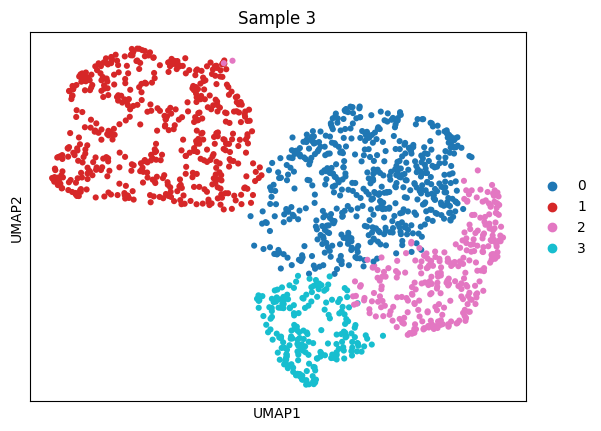

In [74]:
sc.pl.umap(data_counts, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

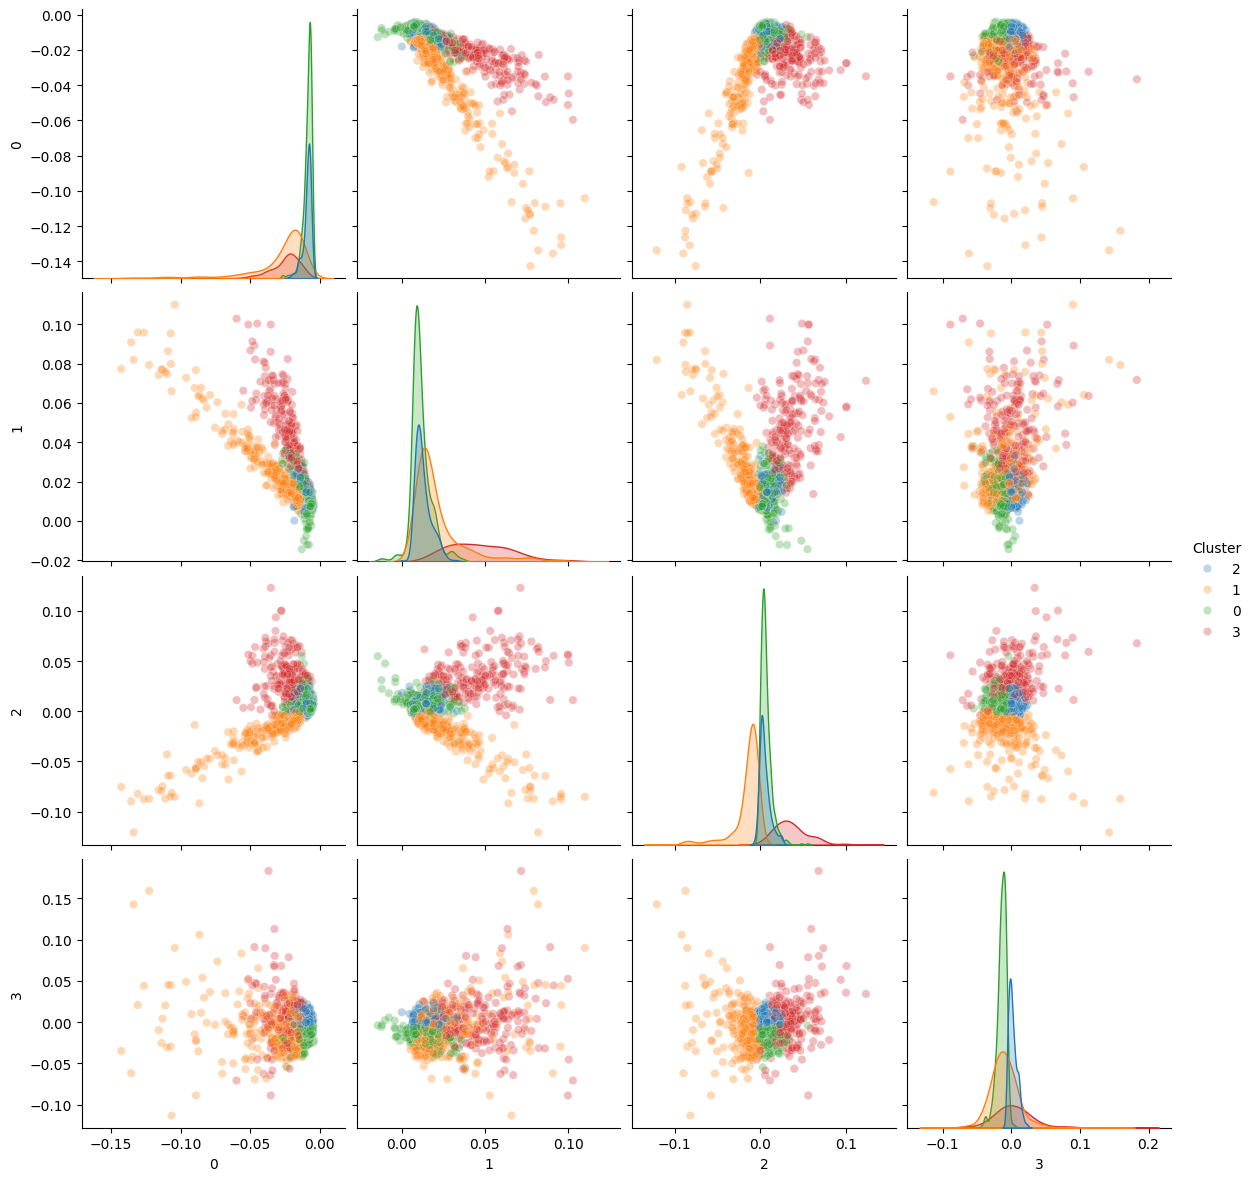

In [75]:
nmd_plot.plot_embedding_grid(data_counts.obsm["X_3b"], hue=data_counts.obs["leiden_opt"], size=3)


In [76]:
pd.crosstab(data_all_pca.obs["leiden_opt"], data_counts.obs["leiden_opt"], rownames=['PCA'], colnames=['NMD'])

NMD    0    1    2    3
PCA                    
0    334   28  155    0
1     20  454    8    0
2    152    3  109  207
3     46   14   13    1

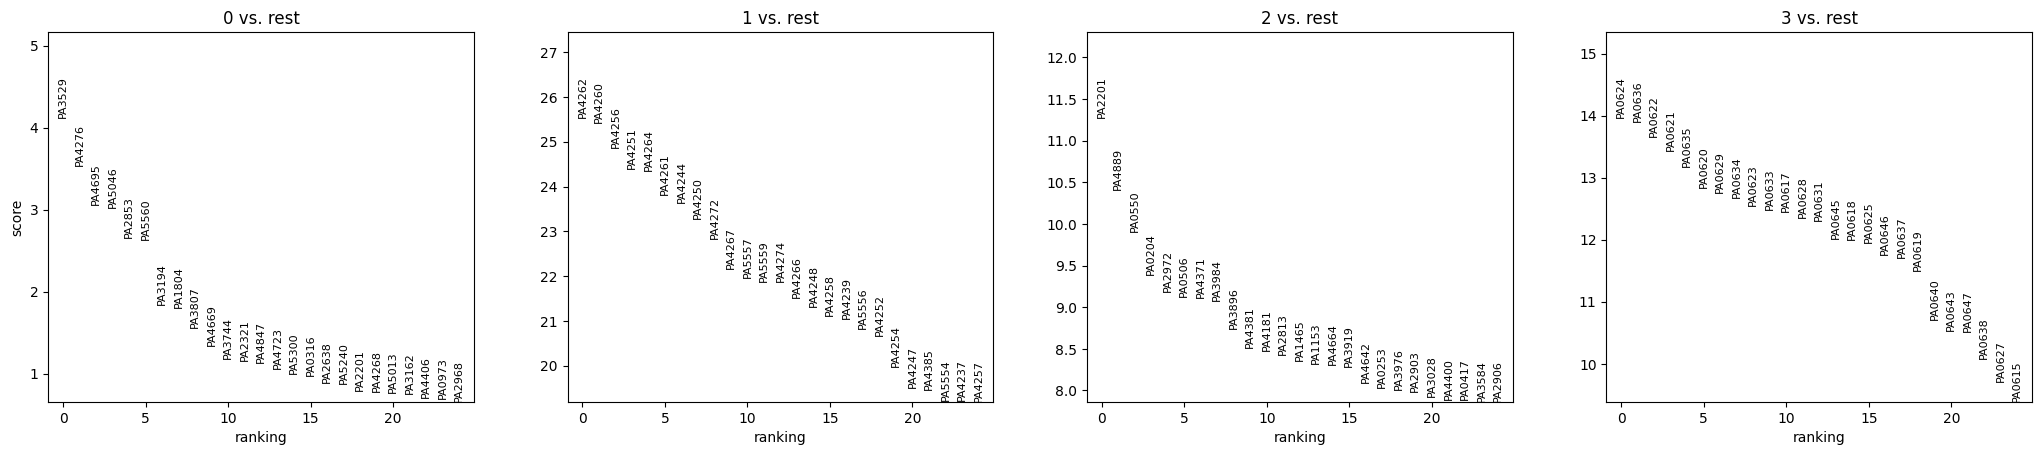

In [77]:
sc.tl.rank_genes_groups(data_all_pca, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_all_pca, n_genes=25, sharey=False)

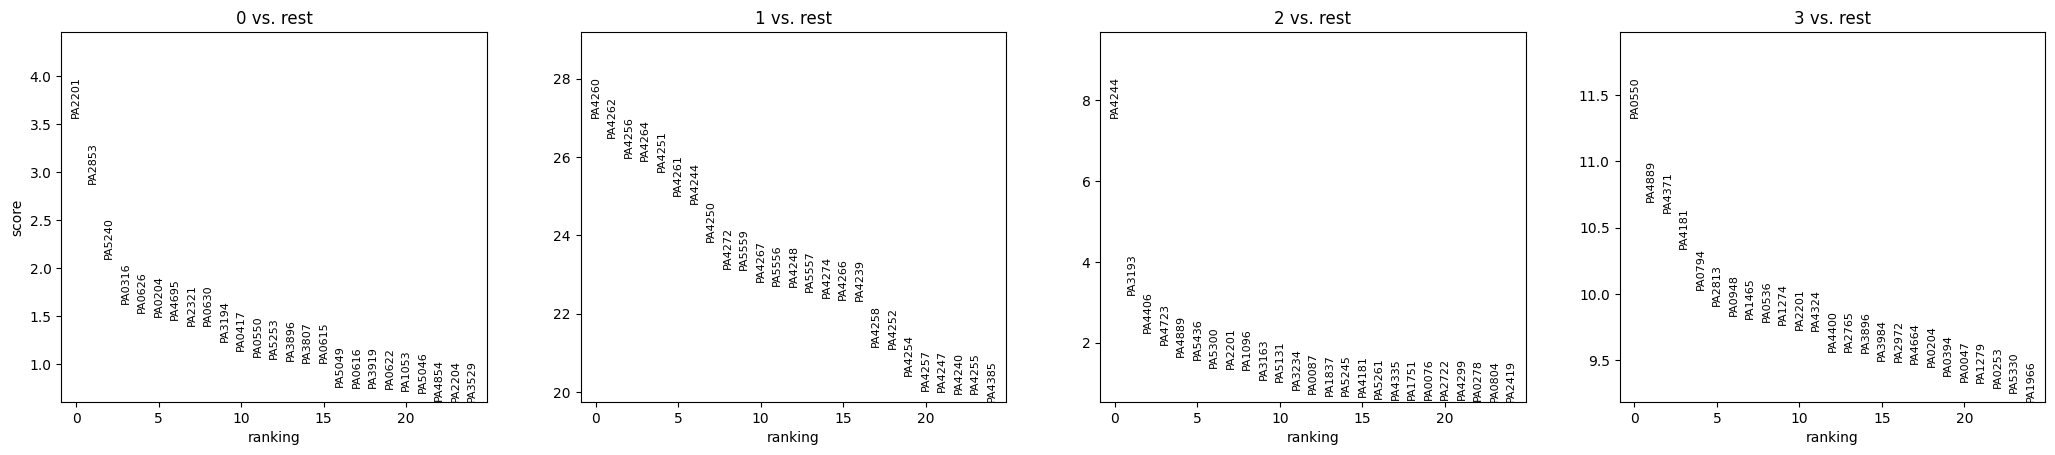

In [78]:
sc.tl.rank_genes_groups(data_counts, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_counts, n_genes=25, sharey=False)

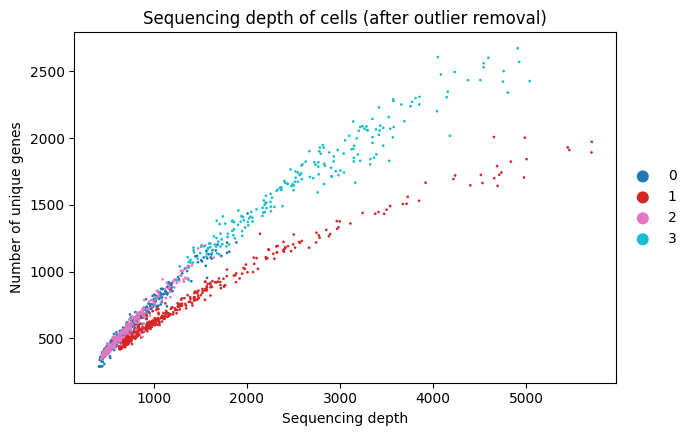

In [79]:
sc.pl.scatter(data_counts, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

In [80]:
top_genes_3 = [x[3] for x in data_counts.uns["rank_genes_groups"]["names"]]
print(top_genes_3[:25])

['PA0550', 'PA4889', 'PA4371', 'PA4181', 'PA0794', 'PA2813', 'PA0948', 'PA1465', 'PA0536', 'PA1274', 'PA2201', 'PA4324', 'PA4400', 'PA2765', 'PA3896', 'PA3984', 'PA2972', 'PA4664', 'PA0204', 'PA0394', 'PA0047', 'PA1279', 'PA0253', 'PA5330', 'PA1966']


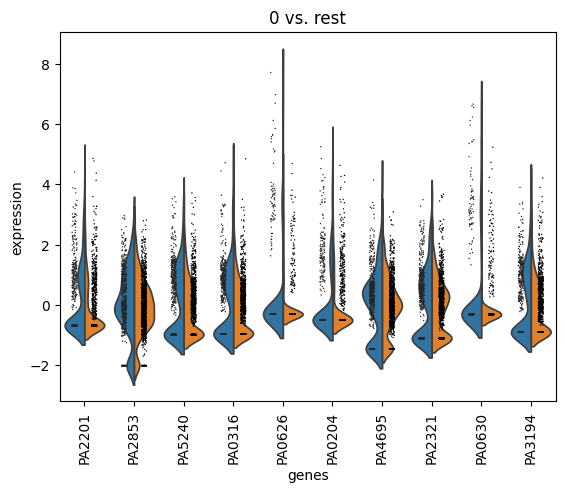

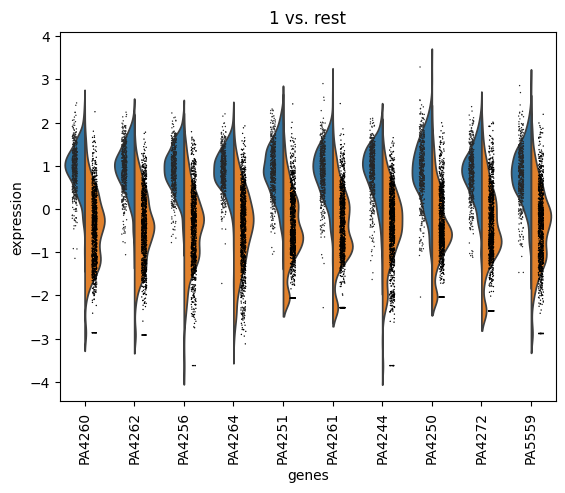

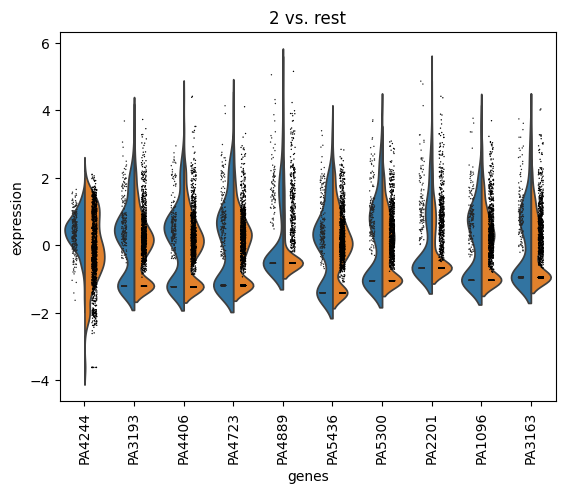

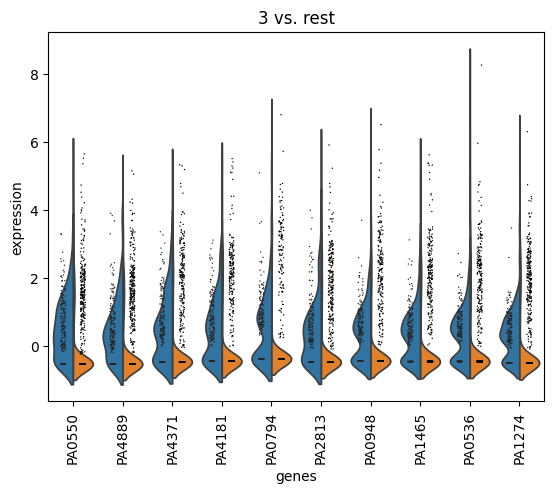

In [81]:
nclust = len(np.unique(data_counts.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_counts, groups=str(i), n_genes=10)